In [2]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import optimize

In [3]:
# Load dataset
exp_name = 'convective_coupling/aquaplanet/d5_sphum'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa
rh_critical = namelist['qe_moist_convection_nml']['rhbm']       # Critical relative humidity used in convection scheme.

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

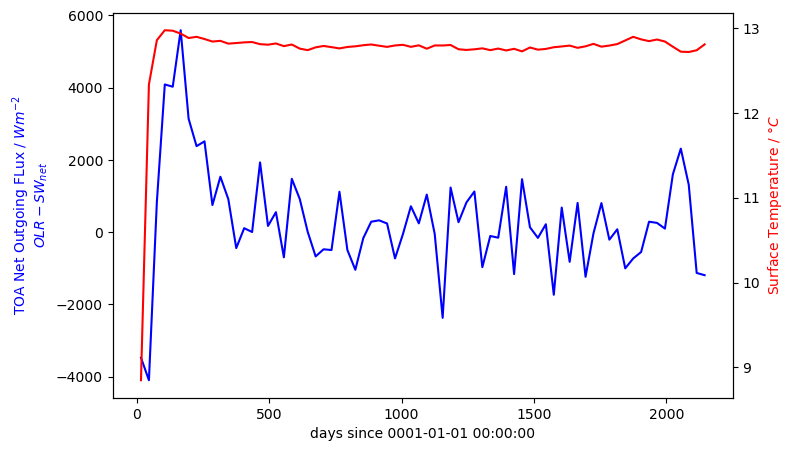

In [4]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# 101325 is the default reference pressure used by Isca if not set in the constants_nml module
# isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau*(p_full/101325)**4)), ds.temp_2m, ax)
isca_tools.plot.plot_spin_up(ds.olr, frierson_net_toa_sw_dwn(ds.swdn_toa, ds.ps, albedo, tau), ds.temp_2m, ax)
# ax.set_ylim([-2000, 2000]);

## Specific humidity vs Saturation
See how the specific humidity computed by *Isca* compares to the saturation specific humidity.

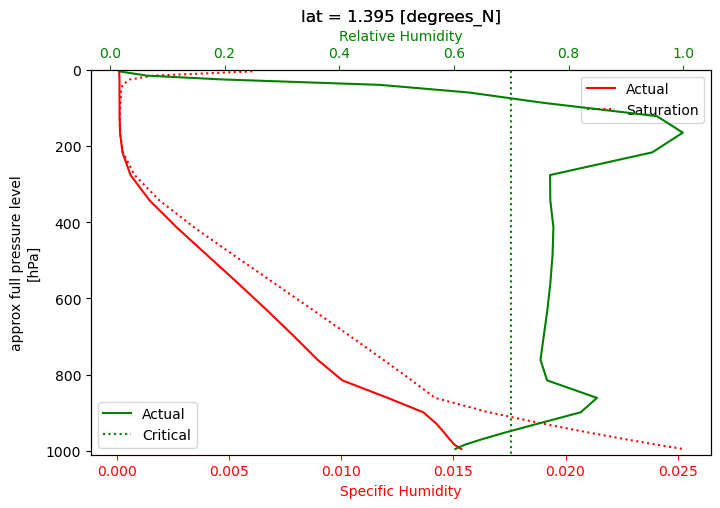

In [5]:
# Take time and zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
ds_use = ds.sel(time=slice(360*3, np.inf)).mean(dim=['lon', 'time'])
ds_tropics = ds_use.sel(lat=[0],method='nearest')

fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.xaxis.label.set_color('r')
ax.spines['bottom'].set_color('red')
ax.tick_params(axis='x', colors='r')
ds_tropics.sphum.plot(y='pfull', yincrease=False, color='r', ax=ax, label='Actual');
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_tropics.temp), ds_tropics.pfull * 100)
ax2 = ax.twiny()
ax2.xaxis.label.set_color('g')
ax2.tick_params(axis='x', colors='g')
ax2.set_xlabel('Relative Humidity')
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
sphum_sat.plot(y='pfull', yincrease=False, ax=ax, color='r', linestyle=':', label='Saturation');

rh = rh_from_sphum(ds_tropics.sphum, ds_tropics.temp, ds_tropics.temp.pfull*100)/100
rh.plot(y='pfull', yincrease=False, ax=ax2, color='g', label='Actual');
rh2 = ds_tropics.sphum / sphum_sat   # T`his is not quite correct formula but gives basically the same result
ax.legend()
ax2.set_xlabel('Relative Humidity');
ax2.vlines(rh_critical, -100, 1100, color='g', linestyle=':', label='Critical')
ax2.legend()
plt.ylim([1010,0])
ax.set_xlabel('Specific Humidity');

From the above plot, we see that near the surface, the specific humidity, $q$, is well below the saturation specific humidity, $q_s$ giving a low relative humidity, $r$.

Then in the free troposphere, $r$, settles to a constant level just above the critical value of 0.7 specified in the `qe_moist_convection_nml` namelist through the option `rhbm`.

In [6]:
pressure_ft = 700  # pressure level of free troposphere in hPa
ds_ft = ds_use.sel(pfull=pressure_ft, method='nearest')

mse_2m = moist_static_energy(ds_use.temp_2m, ds_use.sphum_2m, 2)
mse_LA = moist_static_energy(ds_use.temp[-1], ds_use.sphum[-1], ds_use.height[-1])
mse_ft = moist_static_energy(ds_ft.temp, ds_ft.sphum, ds_ft.height)

mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_ft.temp), ds_ft.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_ft_sat = moist_static_energy(ds_ft.temp, sphum_sat, ds_ft.height)

mix_ratio_rh_crit = mixing_ratio_from_partial_pressure(rh_critical * saturation_vapor_pressure(ds_ft.temp), ds_ft.pfull * 100)
sphum_rh_crit = mix_ratio_rh_crit/(1+mix_ratio_rh_crit)
mse_ft_rh_crit = moist_static_energy(ds_ft.temp, sphum_rh_crit, ds_ft.height)

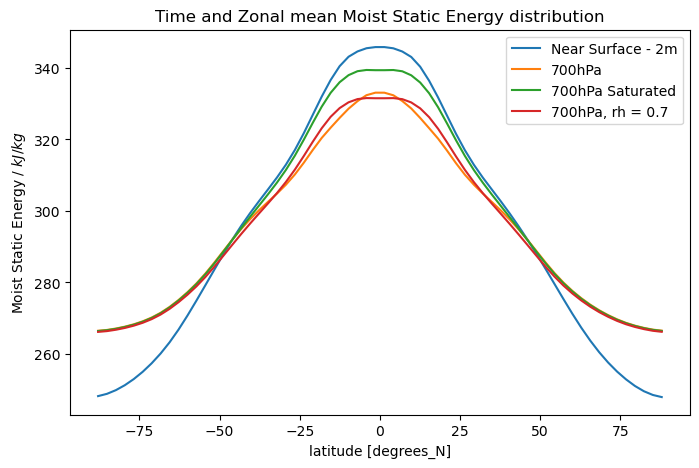

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_2m.plot.line(ax=ax, add_legend=False, label="Near Surface - 2m")
mse_ft.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa")
mse_ft_sat.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa Saturated")
mse_ft_rh_crit.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa, rh = {rh_critical}")
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');

## Lifting Condensation Level

The discrepancy between the blue line and green line in the tropics is because the lifting condensation level computed by Isca is at a [higher altitude](https://github.com/jduffield65/Isca/blob/main/jobs/convective_coupling/aquaplanet/d5/mse_notebook.ipynb) than that computed using the *2m* surface values and then seeing where saturation occurs.

Below we see that the values used for the *near surface* temperature and specific humidity make a difference to this.


In [8]:
lcl_2m = lcl_temp(float(ds_tropics.temp_2m), float(ds_tropics.ps), float(ds_tropics.sphum_2m))
lcl_lower_atmos = lcl_temp(float(ds_tropics.temp[-1]), float(ds_tropics.sphum.pfull[-1])*100, float(ds_tropics.sphum[-1]))

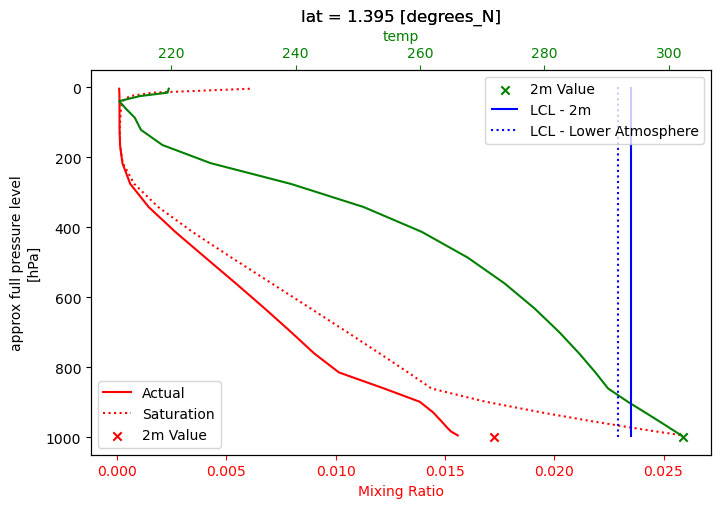

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mix_ratio_tropics = ds_tropics.sphum / (1-ds_tropics.sphum)
mix_ratio_tropics.name = 'mixing ratio'
mix_ratio_tropics.plot(y='pfull', yincrease=False, color='r', label='Actual')
mix_ratio_tropics_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_tropics.temp), ds_tropics.pfull * 100)
mix_ratio_tropics_sat.plot(y='pfull', yincrease=False, color='r', linestyle=':', label='Saturation')
ax.xaxis.label.set_color('r')
ax.tick_params(axis='x', colors='r')
ax2 = ax.twiny()
ax2.xaxis.label.set_color('g')
ax2.tick_params(axis='x', colors='g')
ds_tropics.temp.plot(y='pfull', yincrease=False, ax=ax2, color='g')

# Plot surface values
ax2.scatter(ds_tropics.temp_2m.to_numpy(), ds_tropics.ps.to_numpy()/100, color='g', marker='x',label='2m Value')
mixing_ratio_2m = ds_tropics.sphum_2m / (1-ds_tropics.sphum_2m)
ax.scatter(mixing_ratio_2m.to_numpy(), ds_tropics.ps.to_numpy()/100, color='r', marker='x', label='2m Value')
ax2.vlines(lcl_2m, 1000,0, color='b', label='LCL - 2m')
ax2.vlines(lcl_lower_atmos, 1000,0, color='b', linestyle=':', label='LCL - Lower Atmosphere')
ax.legend(loc='lower left');
ax2.legend(loc='upper right');
ax.set_xlabel('Mixing Ratio');

The plot above, shows the specific mixing ratio and temperature profiles as a function of pressure. I use mixing ratio rather than specific humidity, because one of the assumptions of the [LCL calculation](https://github.com/jduffield65/Isca/blob/main/jobs/convective_coupling/aquaplanet/d5_2/lcl_notebook.ipynb) is that the mixing ratio should remain constant while the temperature profile follows the dry adiabat. This is clearly not the case above.

The most striking thing from the above plot is that the 2m mixing ratio is far higher than that expected from the lower atmosphere (bottom of the solid red line).

Given that the LCL level is where a line vertically up from the surface (red cross for 2m or bottom of the red line for lower atmosphere) intersects the dotted red saturation line, the LCL is at a significantly larger altitude when computed using the lower atmosphere value rather than the 2m value.

## Moist Static Energy using Lower Atmosphere Values
The third plot above is repeated below, but including the Lower atmosphere MSE. Clearly, this is much closer to the 700hPa Saturated MSE than the 2m curve in the tropics.


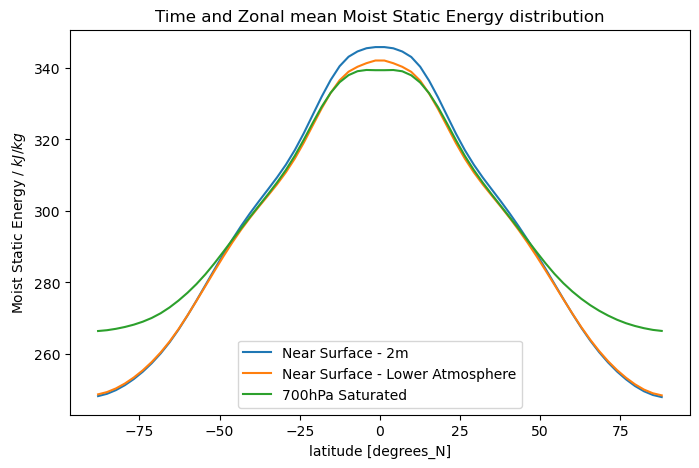

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_2m.plot.line(ax=ax, add_legend=False, label="Near Surface - 2m")
mse_LA.plot.line(ax=ax, add_legend=False, label="Near Surface - Lower Atmosphere")
mse_ft_sat.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa Saturated")
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');

In [11]:
# Consider each latitude and pressure value and compute saturation MSE
mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), ds_use.pfull * 100)
sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
mse_all_sat = moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)
mse_all_sat.name = 'saturation moist static energy';

mse_diff_2m = (mse_2m-mse_all_sat)/mse_2m
mse_diff_2m.name = '(Surface MSE - Saturation MSE)/Surface MSE'

mse_diff_LA = (mse_LA-mse_all_sat)/mse_LA
mse_diff_LA.name = '(Surface MSE - Saturation MSE)/Surface MSE'

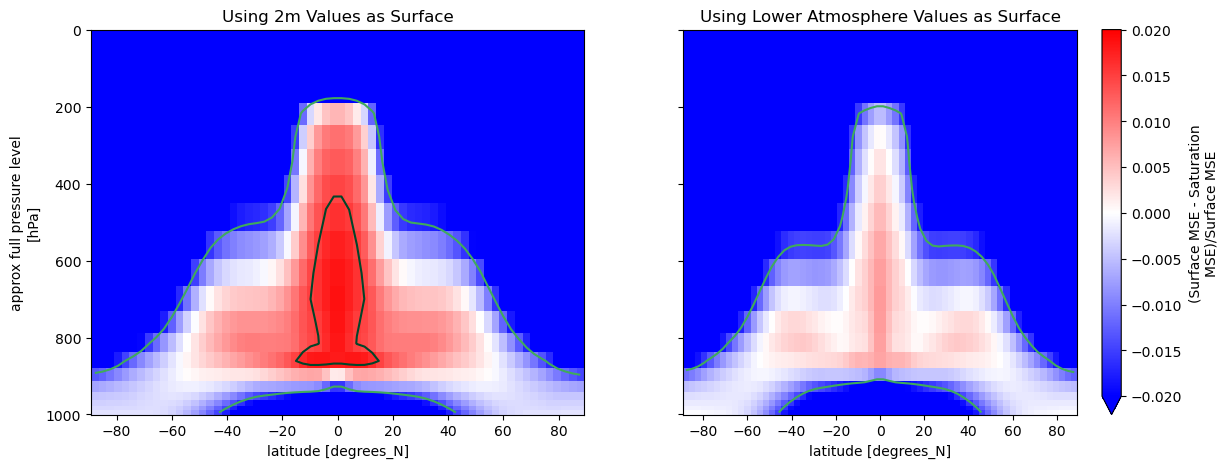

In [66]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
mse_diff_2m.plot.pcolormesh(ax=axs[0], yincrease=False, vmin=-0.02, vmax=0.02, cmap='bwr', x='lat', add_colorbar=False);
mse_diff_LA.plot.pcolormesh(ax=axs[1], yincrease=False, vmin=-0.02, vmax=0.02, cmap='bwr', x='lat');
# Show contour where the dofference falls below 2%
axs[0].contour(mse_diff_2m.lat.to_numpy(), mse_diff_2m.pfull.to_numpy(), mse_diff_2m.to_numpy().transpose(), [-0.015, 0.015],
               cmap='YlGn', vmin=-0.04, vmax=0)
axs[1].contour(mse_diff_LA.lat.to_numpy(), mse_diff_LA.pfull.to_numpy(), mse_diff_LA.to_numpy().transpose(), [-0.015, 0.015],
               cmap='YlGn', vmin=-0.04, vmax=0)
axs[1].set_ylabel('');
axs[0].set_title('Using 2m Values as Surface');
axs[1].set_title('Using Lower Atmosphere Values as Surface');

In the above plots, we clearly see that the surface MSE is much closer to the saturation MSE when the starting point is taken as the lower atmosphere (right) compared to the 2m values (left).

Below, we also see that the temperature profile is much closer to that expected from a convective neutral profile (dry adiabat up to LCL followed by moist adiabat) if the lower atmosphere values are used as a starting point (orange line), rather than the 2m values (blue line).

This applies both to the tropics and extratropics, for the pressure levels where the MSE difference shown above is small - upto about 200hPa in the tropics and 700hPa in the extratropics.

In [31]:
tropics_temp_profile_cn_2m = convection_neutral_profile(float(ds_tropics.temp_2m), float(ds_tropics.ps), float(ds_tropics.sphum_2m),
                               ds_tropics.temp.pfull.to_numpy()*100)
tropics_temp_profile_cn_LA = convection_neutral_profile(float(ds_tropics.temp[-1]), float(ds_tropics.sphum.pfull[-1])*100,
                                                float(ds_tropics.sphum[-1]), ds_tropics.temp.pfull.to_numpy()*100)

# For extratropics, average between 40-60 degrees latitude
# ds_extrop = area_weight_mean_lat(ds_use.sel(lat=slice(40,60)))
ds_extrop = xr.concat([ds_use.sel(lat=slice(-60,-40)), ds_use.sel(lat=slice(40,60))], dim='lat')
ds_extrop = area_weight_mean_lat(ds_extrop)
extrop_temp_profile_cn_2m = convection_neutral_profile(float(ds_extrop.temp_2m), float(ds_extrop.ps), float(ds_extrop.sphum_2m),
                               ds_extrop.temp.pfull.to_numpy()*100)
extrop_temp_profile_cn_LA = convection_neutral_profile(float(ds_extrop.temp[-1]), float(ds_extrop.sphum.pfull[-1])*100,
                                                float(ds_extrop.sphum[-1]), ds_extrop.temp.pfull.to_numpy()*100)

Variables Averaged: ['p', 'k', 'h', 'e', 'i', 'g', 'h', 't', 't', 'e', 'm', 'p', 'p', 's', 's', 'p', 'h', 'u', 'm', 'o', 'l', 'r', 's', 'w', 'd', 'n', '_', 't', 'o', 'a', 's', 'p', 'h', 'u', 'm', '_', '2', 'm', 't', 'e', 'm', 'p', '_', '2', 'm', 'r', 'h', '_', '2', 'm', 'a', 'v', 'e', 'r', 'a', 'g', 'e', '_', 'T', '1', 'a', 'v', 'e', 'r', 'a', 'g', 'e', '_', 'T', '2', 'a', 'v', 'e', 'r', 'a', 'g', 'e', '_', 'D', 'T', 't', 'i', 'm', 'e', '_', 'b', 'o', 'u', 'n', 'd', 's']


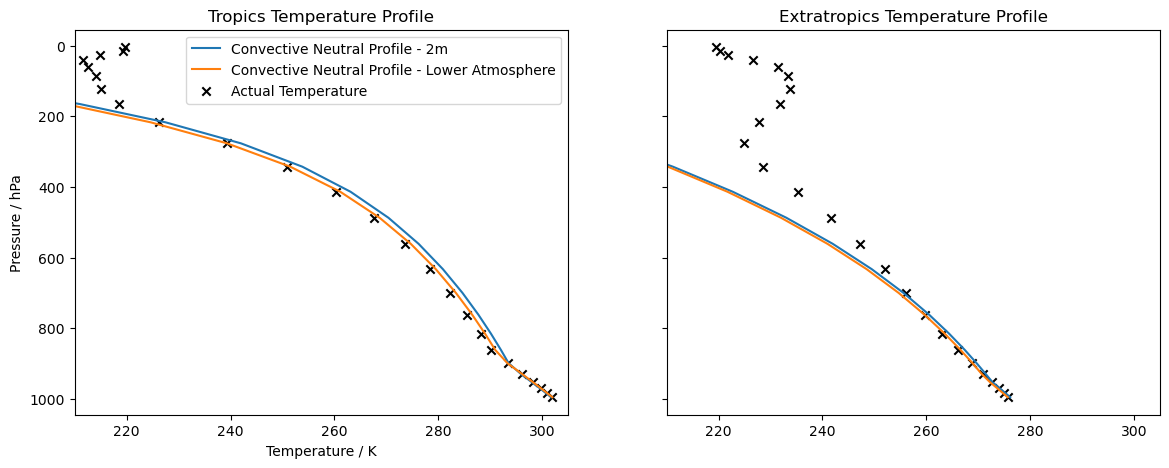

In [32]:
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
axs[0].plot(tropics_temp_profile_cn_2m, ds_tropics.temp.pfull.to_numpy(), label='Convective Neutral Profile - 2m')
axs[0].plot(tropics_temp_profile_cn_LA, ds_tropics.temp.pfull.to_numpy(), label='Convective Neutral Profile - Lower Atmosphere')
axs[0].scatter(ds_tropics.temp.to_numpy(), ds_tropics.temp.pfull.to_numpy(), label='Actual Temperature', color='k', marker='x')
axs[0].invert_yaxis()
axs[1].plot(extrop_temp_profile_cn_2m, ds_extrop.temp.pfull.to_numpy(), label='Convective Neutral Profile - 2m')
axs[1].plot(extrop_temp_profile_cn_LA, ds_extrop.temp.pfull.to_numpy(), label='Convective Neutral Profile - Lower Atmosphere')
axs[1].scatter(ds_extrop.temp, ds_extrop.temp.pfull.to_numpy(), label='Actual Temperature', color='k', marker='x')
axs[0].set_xlim([210, 305]);
axs[0].legend();
axs[0].set_xlabel('Temperature / K');
axs[0].set_ylabel('Pressure / hPa');
axs[0].set_title('Tropics Temperature Profile');
axs[1].set_title('Extratropics Temperature Profile');

In [39]:
mse_diff_2m.lat.to_numpy().shape

(64,)